### Kaggle Competition - m5 forecasting accuracy
#### Submission by imogen.taylor

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import gc
from scipy.sparse import csr_matrix
from statsmodels.tsa.arima_model import ARIMA
from random import random
from numpy import load
from numpy import loadtxt
from numpy import nan
from numpy import isnan
from numpy import count_nonzero
from numpy import unique
from numpy import array
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
#import lightgbm as lgb
#from sklearn.model_selection import train_test_split
import multiprocessing as mp
import re
from IPython.display import display
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


In [16]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [17]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#### Read in Data

In [18]:
sales = pd.read_csv("data/sales_train_validation.csv")
sales = sales.iloc[:,1:]

calendar = pd.read_csv("data/calendar.csv")
calendar = reduce_mem_usage(calendar)

sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission = reduce_mem_usage(sample_submission)

sell_prices = pd.read_csv("data/sell_prices.csv")
sell_prices = reduce_mem_usage(sell_prices)

sales_eval = pd.read_csv("data/sales_train_evaluation.csv")
sales_eval = sales_eval.iloc[:,1:]
col_obj = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales_eval[col_obj] = sales_eval[col_obj].astype(str)

Mem. usage decreased to  0.13 Mb (44.2% reduction)
Mem. usage decreased to  2.33 Mb (83.3% reduction)
Mem. usage decreased to 156.58 Mb (40.0% reduction)


In [302]:
display_all(sales_eval.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,...,d_1442,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1

In [303]:
display_all(sales.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,d_494,...,d_1414,d_1415,d_1416,d_1417,d_1418,d_1419,d_1420,d_1421,d_1422,d_1423,d_1424,d_1425,d_1426,d_1427,d_1428,d_1429,d_1430,d_1431,d_1432,d_1433,d_1434,d_1435,d_1436,d_1437,d_1438,d_1439,d_1440,d_1441,d_1442,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1

#### Exploratory Data Analysis
To preserve memory, don't run this section

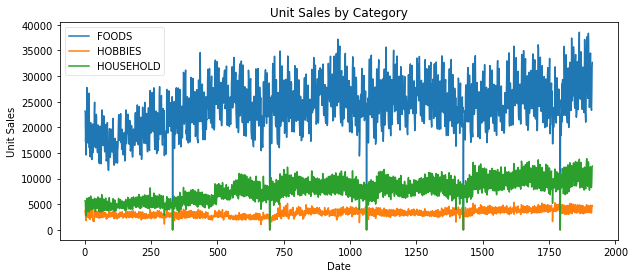

In [7]:
%matplotlib inline
fig = plt.figure(facecolor='w',figsize=(10,4))
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(cat_sales[cat_sales['cat_id']=='FOODS']['d'], cat_sales[cat_sales['cat_id']=='FOODS']['unit_sales'], label='FOODS')
ax.plot(cat_sales[cat_sales['cat_id']=='HOBBIES']['d'], cat_sales[cat_sales['cat_id']=='HOBBIES']['unit_sales'], label='HOBBIES')
ax.plot(cat_sales[cat_sales['cat_id']=='HOUSEHOLD']['d'], cat_sales[cat_sales['cat_id']=='HOUSEHOLD']['unit_sales'], label='HOUSEHOLD')
ax.set_xlabel('Date')
ax.set_ylabel('Unit Sales')
ax.set_title(label = 'Unit Sales by Category')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

In [7]:
state_sales = sales.groupby(['state_id','d'])['unit_sales'].sum().reset_index()

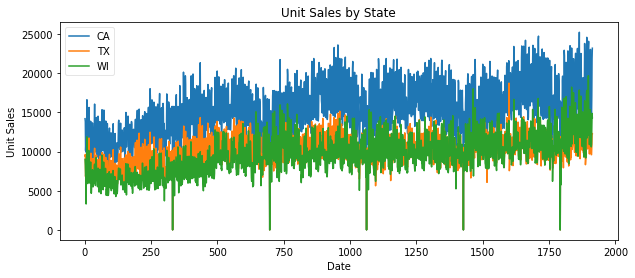

In [8]:
%matplotlib inline
fig = plt.figure(facecolor='w',figsize=(10,4))
ax = fig.add_subplot(111,axisbelow=True)
for i in state_sales['state_id'].unique():
    ax.plot(state_sales[(state_sales['state_id']==i)]['d'], state_sales[(state_sales['state_id']==i)]['unit_sales'], label=i)
ax.set_xlabel('Date')
ax.set_ylabel('Unit Sales')
ax.set_title(label = 'Unit Sales by State')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

In [11]:
store_sales = sales.groupby(['state_id','store_id','d'])['unit_sales'].sum().reset_index()

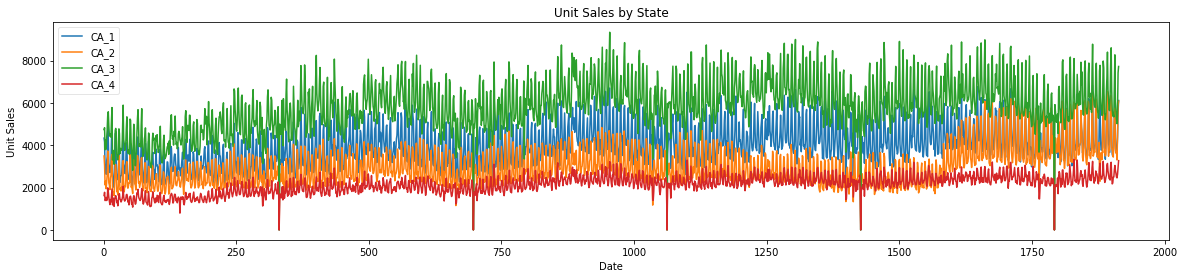

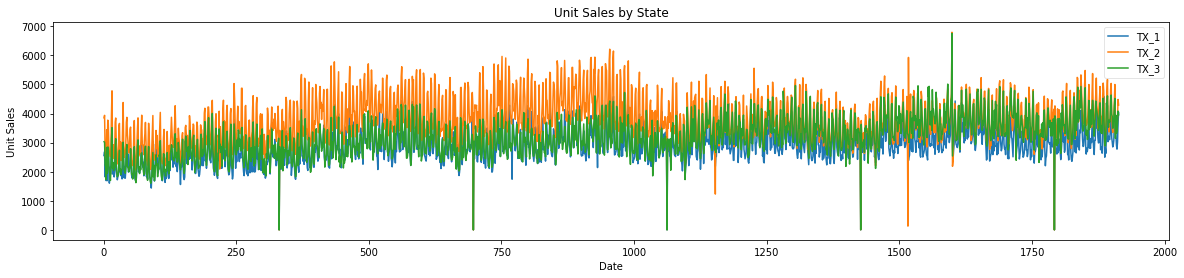

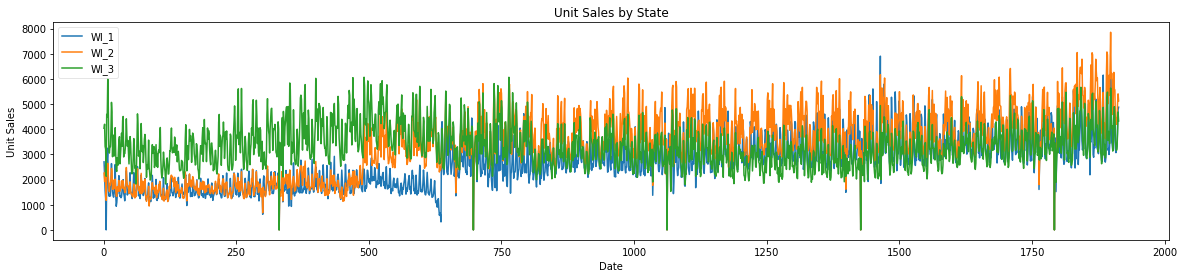

In [14]:
%matplotlib inline
for j in store_sales['state_id'].unique():
    fig = plt.figure(facecolor='w',figsize=(20,4))
    ax = fig.add_subplot(111,axisbelow=True)
    for i in store_sales[store_sales['state_id']==j]['store_id'].unique():
        ax.plot(store_sales[(store_sales['store_id']==i)]['d'], store_sales[(store_sales['store_id']==i)]['unit_sales'], label=i)
    ax.set_xlabel('Date')
    ax.set_ylabel('Unit Sales')
    ax.set_title(label = 'Unit Sales by State')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.show()

#### WRMSSE Function
This is the function used to determine "goodness of fit" as per the competition guidelines

Write function to test fit of the model on the validation set

The very simplify version of WRMSSE is <math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <semantics>
    <mrow>
      <mi>W</mi>
      <mi>R</mi>
      <mi>M</mi>
      <mi>S</mi>
      <mi>S</mi>
      <mi>E</mi>
      <mo>=</mo>
      <munderover>
        <mo>&#x2211;<!-- ∑ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>i</mi>
          <mo>=</mo>
          <mn>1</mn>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mn>42840</mn>
        </mrow>
      </munderover>
      <mo stretchy="false">(</mo>
      <mi>W</mi>
      <msub>
        <mn>2</mn>
        <mi>i</mi>
      </msub>
      <mo>&#x2217;<!-- ∗ --></mo>
      <msqrt>
        <mfrac>
          <mrow>
            <mo>&#x2211;<!-- ∑ --></mo>
            <mrow class="MJX-TeXAtom-ORD">
              <mo stretchy="false">(</mo>
              <mi>y</mi>
              <mo>&#x2212;<!-- − --></mo>
              <msup>
                <mi>y</mi>
                <mo>&#x2032;</mo>
              </msup>
              <msup>
                <mo stretchy="false">)</mo>
                <mn>2</mn>
              </msup>
            </mrow>
          </mrow>
          <mrow>
            <mi>W</mi>
            <mn>1</mn>
          </mrow>
        </mfrac>
      </msqrt>
      <mo stretchy="false">)</mo>
    </mrow>
    <annotation encoding="application/x-tex">\begin{equation}
WRMSSE = \sum_{i=1}^{42840} (W2_i * \sqrt{\frac{\sum{(y-y')^2}}{W1}})
\end{equation}</annotation>
  </semantics>
</math>
 
So the functions below will be seperated into cal_weight1 and cal_weight2. Then, it will be merged together into wrmsse

In [19]:
def rmse(df, gt):
    df = transform(df)
    gt = transform(gt)
    return mean_squared_error(df["sale"], gt["sale"])

def transform(df):
    newdf = pd.melt(df, id_vars=["id"], var_name="d", value_name="sale")
    newdf.sort_values(by=['id', "d"], inplace=True)
    newdf.reset_index(inplace=True)
    return newdf

NUM_ITEMS = sales.shape[0]    # 30490
# To make it simpler, I will run only the last 10 days
DAYS_PRED = 10

# Get list of all products
idcols = ["id", "item_id", "state_id", "store_id", "cat_id", "dept_id"]
product = sales[idcols]

# create weight matrix
pd.get_dummies(product.state_id, drop_first=False)
weight_mat = np.c_[
   np.ones([NUM_ITEMS,1]).astype(np.int8), # level 1
   pd.get_dummies(product.state_id, drop_first=False).values,
   pd.get_dummies(product.store_id, drop_first=False).values,
   pd.get_dummies(product.cat_id, drop_first=False).values,
   pd.get_dummies(product.dept_id, drop_first=False).values,
   pd.get_dummies(product.state_id + product.cat_id, drop_first=False).values,
   pd.get_dummies(product.state_id + product.dept_id, drop_first=False).values,
   pd.get_dummies(product.store_id + product.cat_id, drop_first=False).values,
   pd.get_dummies(product.store_id + product.dept_id, drop_first=False).values,
   pd.get_dummies(product.item_id, drop_first=False).values,
   pd.get_dummies(product.state_id + product.item_id, drop_first=False).values,
   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
].T

weight_mat = weight_mat.astype("int8")
weight_mat, weight_mat.shape

weight_mat_csr = csr_matrix(weight_mat)
del weight_mat; gc.collect()

def cal_weight1(product):
    sales_train_val = sales
    d_name = ['d_' + str(i+1) for i in range(1913)]

    sales_train_val = weight_mat_csr * sales_train_val[d_name].values


    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))

    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))<1

    sales_train_val = np.where(flag, np.nan, sales_train_val)

    # denominator of RMSSE / RMSSE
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no)
    
    return weight1

weight1 = cal_weight1(product)

def cal_weight2(data):
    # calculate the sales amount for each item/level
    df_tmp = data
    df_tmp['amount'] = df_tmp['sale'] * df_tmp['sell_price']
    df_tmp =df_tmp.groupby(['id'])['amount'].apply(np.sum)
    df_tmp = df_tmp.values
    
    weight2 = weight_mat_csr * df_tmp 

    weight2 = weight2/np.sum(weight2)
    return weight2  

# Get the last 28 days for weight2
cols = ["d_{}".format(i) for i in range(1886, 1886+28)]

data = sales[["id", 'store_id', 'item_id'] + cols]

data = pd.melt(data, id_vars=["id", 'store_id', 'item_id'], var_name="d", value_name="sale")
data = pd.merge(data, calendar, how = 'left', left_on = ['d'], right_on = ['d'])
data = data[["id", 'store_id', 'item_id', "sale", "wm_yr_wk"]]
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

weight2 = cal_weight2(data)

def wrmsse(preds, y_true):
    # number of columns
    num_col = DAYS_PRED

    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
    
          
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return score

Example using sample submission data 

In [20]:
DAYS_PRED = 28
dayCols = ["d_{}".format(i) for i in range(1885, 1885+DAYS_PRED)]
gt = sales[["id"]+dayCols]

dayCols = ["F{}".format(i) for i in range(1, DAYS_PRED+1)]
df = sample_submission[["id"]+dayCols].iloc[:len(gt),:]

# WRMSSE score

dft = transform(df)
gtt = transform(gt)
wrmsse(dft["sale"].values, gtt["sale"].values)

8.0842691558116346

In [21]:
len(dft["sale"].values)

853720

### Data Processing

In [21]:
DAYS_PRED = 28
History = 365 # 1 years of history for simplicity
maxd = len([x for x in sales_eval.columns if x not in ['id','item_id','dept_id','cat_id','store_id','state_id']])
dayColsTrain = ["d_{}".format(i) for i in range(maxd+1-DAYS_PRED-DAYS_PRED-History, maxd+1-DAYS_PRED-DAYS_PRED)]
dayColsValid = ["d_{}".format(i) for i in range(maxd+1-DAYS_PRED-DAYS_PRED, maxd-DAYS_PRED+1)]
dayColsEvaluate = ["d_{}".format(i) for i in range(maxd+1-DAYS_PRED, maxd+1)]

print('Train: ',maxd+1-DAYS_PRED-DAYS_PRED-History, maxd+1-DAYS_PRED-DAYS_PRED-1)
print('Valid: ',maxd+1-DAYS_PRED-DAYS_PRED, maxd-DAYS_PRED+1-1)
print('Evaluate: ',maxd+1-DAYS_PRED, maxd+1-1)
print(maxd)

def encode_cat(df):
    df1 = df
    dic = {}
    obj_df = df1.select_dtypes(include=['object']).copy()
    for n in ([x for x in obj_df.columns if x not in ['d','id']]):
        df1[n] = df1[n].astype('category')
        dic[n] = dict(enumerate(df[n].cat.categories))
        df1[n] = df1[n].cat.codes
    return(df1, dic)

def transform_calendar(df):
    df1 = add_datepart(df,'date')
    df1, dic = encode_cat(df1)
    df1 = df1.drop(['weekday','Unnamed: 0'],axis=1)
    return(df1)

def train_test_valid(df, dayCols):
    df1 = df[["id","item_id","dept_id","cat_id","store_id","state_id"]+dayCols]
    df1 = pd.melt(df1, id_vars=["id","item_id","dept_id","cat_id","store_id","state_id"], var_name="d", value_name="sale").reset_index()
    df1['t'] =  pd.to_numeric(df1['d'].str.replace('d_',''))
    df1 = df1.drop(['index'],axis=1)
    df1['sale'] = np.float64(df1['sale'])
    return(df1)

def add_datepart(df,datefield):
    df[datefield] = pd.to_datetime(df[datefield])
    fld = df[datefield]
    targ_pre = re.sub('[Dd]ate$','',datefield)
    for n in (['Year','Month','Week','Day','Dayofweek','Dayofyear','Is_month_end','Is_month_start','Is_quarter_end',
              'Is_quarter_start','Is_year_end','Is_year_start']):
        df[targ_pre+n] = getattr(fld.dt, n.lower())
        df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(datefield,axis=1,inplace=True)
    return(df)
    
def create_dataset(df, calendar, dayCols):
    df1 = train_test_valid(df, dayCols)
    df1 = df1.merge(calendar, on='d')
    return(df1)

Train:  1521 1885
Valid:  1886 1913
Evaluate:  1914 1941
1941


In [22]:
calendar1 = transform_calendar(calendar)
sales_transform, dictionary = encode_cat(sales)
sales_eval_transform, dictionary_eval = encode_cat(sales_eval)
train = create_dataset(sales_transform, calendar1, dayColsTrain)
valid = create_dataset(sales_transform, calendar1, dayColsValid)
evaluate = create_dataset(sales_eval_transform, calendar1, dayColsEvaluate)

In [318]:
print(len(train))
print(len(valid))
print(len(evaluate))
display_all(train.head())

11128850
853720
853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,t,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Year,Elapsed,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1521,2.0,1521,11509,2,3,2015,-1,-1,-1,-1,0,0,0,2015,1520,3,13,29,6,88,False,False,False,False,False,False
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1521,0.0,1521,11509,2,3,2015,-1,-1,-1,-1,0,0,0,2015,1520,3,13,29,6,88,False,False,False,False,False,False
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1521,0.0,1521,11509,2,3,2015,-1,-1,-1,-1,0,0,0,2015,1520,3,13,29,6,88,False,False,False,False,False,False
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1521,0.0,1521,11509,2,3,2015,-1,-1,-1,-1,0,0,0,2015,1520,3,13,29,6,88,False,False,False,False,False,False
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1521,1.0,1521,11509,2,3,2015,-1,-1,-1,-1,0,0,0,2015,1520,3,13,29,6,88,False,False,False,False,False,False


In [319]:
train.to_csv("data/train.csv")
valid.to_csv("data/valid.csv")
evaluate.to_csv("data/evaluate.csv")

In [ ]:
train = reduce_mem_usage(train)
valid = reduce_mem_usage(valid)
evaluate = reduce_mem_usage(evaluate)

In [21]:
display_all(train.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,t,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Year,Elapsed,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,14370,1437,3,1,0,0,d_1493,0.0,1493,11505,2,3,2015,-1,-1,-1,-1,1,1,0,2015,1492,3,9,1,6,60,False,True,False,False,False,False
1,14380,1438,3,1,0,0,d_1493,0.0,1493,11505,2,3,2015,-1,-1,-1,-1,1,1,0,2015,1492,3,9,1,6,60,False,True,False,False,False,False
2,14390,1439,3,1,0,0,d_1493,1.0,1493,11505,2,3,2015,-1,-1,-1,-1,1,1,0,2015,1492,3,9,1,6,60,False,True,False,False,False,False
3,14400,1440,3,1,0,0,d_1493,1.0,1493,11505,2,3,2015,-1,-1,-1,-1,1,1,0,2015,1492,3,9,1,6,60,False,True,False,False,False,False
4,14410,1441,3,1,0,0,d_1493,2.0,1493,11505,2,3,2015,-1,-1,-1,-1,1,1,0,2015,1492,3,9,1,6,60,False,True,False,False,False,False


### Modelling

In [256]:
train = pd.read_csv("data/train.csv").drop('Unnamed: 0',axis=1)
# train = reduce_mem_usage(train)
valid = pd.read_csv("data/valid.csv").drop('Unnamed: 0',axis=1)
# valid = reduce_mem_usage(valid)
evaluate = pd.read_csv("data/evaluate.csv").drop('Unnamed: 0',axis=1)
# evaluate = reduce_mem_usage(evaluate)

In [28]:
# train = reduce_mem_usage(train)
# valid = reduce_mem_usage(valid)
# evaluate = reduce_mem_usage(evaluate)

Mem. usage decreased to 604.96 Mb (50.4% reduction)
Mem. usage decreased to 45.59 Mb (51.3% reduction)
Mem. usage decreased to 45.59 Mb (51.3% reduction)


In [59]:
correlation = train.corr(method='pearson')
#correlation

Split into train and validation group, use train as dates up 28 days before end of the sample, and validation as final 28 days

In [23]:
target = 'sale'
drop_cols = ['event_name_2','event_type_2','Dayofweek','Year','Month']
X_train = train.drop([target,'d']+drop_cols, axis=1)
y_train = train[target]
X_valid = valid.drop([target,'d']+drop_cols, axis=1)
y_valid = valid[target]
X_evaluate = evaluate.drop([target,'d']+drop_cols, axis=1)
y_evaluate = evaluate[target]
del train, valid, evaluate

#### Decision Tree with depth 3

In [312]:
%%time
m = Lasso()
m.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m.predict(X_valid.drop('id',axis=1))
print(wrmsse(yhat_valid, y_valid))

2.24961328258
CPU times: user 27.1 s, sys: 5.59 s, total: 32.7 s
Wall time: 25.8 s


In [313]:
%%time
m = ElasticNet()
m.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m.predict(X_valid.drop('id',axis=1))
print(wrmsse(yhat_valid, y_valid))

2.26347068392
CPU times: user 58.5 s, sys: 5.58 s, total: 1min 4s
Wall time: 29.3 s


In [66]:
%%time
m = PassiveAggressiveRegressor()
m.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m.predict(X_valid.drop('id',axis=1))
print(wrmsse(yhat_valid, y_valid))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
5.11102574711


In [67]:
%%time
m = SGDRegressor()
m.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m.predict(X_valid.drop('id',axis=1))
print(wrmsse(yhat_valid, y_valid))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
1.69060669933e+16


In [ ]:
%time
m = RandomForestRegressor(n_jobs=14, n_estimators = 1, max_depth = 3)
m.fit(X_train.drop('id',axis=1), y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [ ]:
yhat_valid = m.predict(X_valid.drop('id',axis=1), n_jobs=14)
print(wrmsse(yhat_valid, y_valid))

In [37]:
%time
m = AdaBoostRegressor(n_estimators= 2, learning_rate = 0.5)
m.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m.predict(X_valid.drop('id',axis=1))
print(wrmsse(yhat_valid, y_valid))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
1.5234773031


In [211]:
%%time
m3 = AdaBoostRegressor(n_estimators= 10, learning_rate = 0.25)
m3.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m3.predict(X_valid.drop('id',axis=1))
yhat_evaluate = m3.predict(X_evaluate.drop('id',axis=1))
print('Valid WRMSSE: ',wrmsse(yhat_valid, y_valid))
print('Evaluate WRMSSE: ',wrmsse(yhat_evaluate, y_evaluate))

Valid WRMSSE:  1.70894820061
Evaluate WRMSSE:  1.59895158458
CPU times: user 16min 20s, sys: 22.4 s, total: 16min 43s
Wall time: 16min 42s


Submission 1

In [321]:
%%time
###Submission1
m2 = AdaBoostRegressor(n_estimators= 10, learning_rate = 0.1)
m2.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m2.predict(X_valid.drop('id',axis=1))
yhat_evaluate = m2.predict(X_evaluate.drop('id',axis=1))
print('Valid WRMSSE: ',wrmsse(yhat_valid, y_valid))
print('Evaluate WRMSSE: ',wrmsse(yhat_evaluate, y_evaluate))

Valid WRMSSE:  1.5513224376
Evaluate WRMSSE:  1.52306395993
CPU times: user 13min 1s, sys: 16.2 s, total: 13min 17s
Wall time: 13min 17s


In [325]:
y_valid_eval = y_valid + y_evaluate
yhat_valid_eval = yhat_valid + yhat_evaluate
print('Evaluate WRMSSE: ',wrmsse(yhat_valid_eval, y_valid_eval))

Evaluate WRMSSE:  2.93286838604


Submission 2

In [347]:
%%time
#submission2
m2 = AdaBoostRegressor(n_estimators= 20, learning_rate = 0.1)
m2.fit(X_train.drop('id',axis=1), y_train)

CPU times: user 27min 50s, sys: 28.7 s, total: 28min 19s
Wall time: 28min 19s


In [348]:
#submission2
yhat_valid = m2.predict(X_valid.drop(['id','yhat','F'],axis=1, errors='ignore'))
yhat_evaluate = m2.predict(X_evaluate.drop(['id','yhat','F'],axis=1,errors='ignore'))
print('Valid WRMSSE: ',wrmsse(yhat_valid, y_valid))
print('Evaluate WRMSSE: ',wrmsse(yhat_evaluate, y_evaluate))
y_valid_eval = y_valid + y_evaluate
yhat_valid_eval = yhat_valid + yhat_evaluate
print('Evaluate WRMSSE: ',wrmsse(yhat_valid_eval, y_valid_eval))

Valid WRMSSE:  1.66014389946
Evaluate WRMSSE:  1.56376809248
Evaluate WRMSSE:  3.08852980407


Submission 3

In [24]:
%%time
#submission2
m2 = AdaBoostRegressor(n_estimators= 80, learning_rate = 0.05)
m2.fit(X_train.drop('id',axis=1), y_train)
yhat_valid = m2.predict(X_valid.drop(['id','yhat','F'],axis=1, errors='ignore'))
yhat_evaluate = m2.predict(X_evaluate.drop(['id','yhat','F'],axis=1,errors='ignore'))
print('Valid WRMSSE: ',wrmsse(yhat_valid, y_valid))
print('Evaluate WRMSSE: ',wrmsse(yhat_evaluate, y_evaluate))
y_valid_eval = y_valid + y_evaluate
yhat_valid_eval = yhat_valid + yhat_evaluate
print('Evaluate WRMSSE: ',wrmsse(yhat_valid_eval, y_valid_eval))

Valid WRMSSE:  2.02110344174
Evaluate WRMSSE:  1.87053916457
Evaluate WRMSSE:  3.77064260858
CPU times: user 1h 22min 36s, sys: 1min 37s, total: 1h 24min 14s
Wall time: 1h 24min 7s


### Output Submission

In [213]:
import pickle
s = pickle.dumps(m2)
#m2 = pickle.loads(s)

In [331]:
X_valid.head()

,id,item_id,dept_id,cat_id,store_id,state_id,t,wm_yr_wk,wday,month,...,Day,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,yhat,F
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1886,11609,3,3,...,28,88,False,False,False,False,False,False,0.761366,F1
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1886,11609,3,3,...,28,88,False,False,False,False,False,False,0.761366,F1
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1886,11609,3,3,...,28,88,False,False,False,False,False,False,0.761366,F1
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1886,11609,3,3,...,28,88,False,False,False,False,False,False,0.761366,F1
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1886,11609,3,3,...,28,88,False,False,False,False,False,False,0.761366,F1


In [349]:
def createF(row,n):
    return 'F'+str(row['t']-n)

def format_submission(df,n):
    df_sub = df.drop(['yhat','F'],axis=1, errors='ignore')
    df_sub['yhat'] = m2.predict(df_sub.drop('id',axis=1))
    df_sub['F'] = df_sub.apply(lambda row: createF(row,n), axis=1)
    df_sub = df_sub[['F','yhat','id']]
    #df_sub['id'] = df_sub['id'].map(dictionary['id'])
    df_sub = df_sub.pivot(values='yhat', index='id', columns='F').reset_index()
    df_sub = df_sub[['id']+["F{}".format(i) for i in range(1,DAYS_PRED+1)]]
    return(df_sub)

In [350]:
X_valid_sub = format_submission(X_valid,1885)
X_evaluate_sub = format_submission(X_evaluate,1913)
X_submission = X_valid_sub.append(X_evaluate_sub)

In [344]:
print(sample_submission.shape)
print(X_submission.shape)
print(len(X_submission['id'].unique()))
X_submission.head()

(60980, 30)
(60980, 29)
60980


F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878,1.253805,1.253805,...,1.253805,1.327878,1.327878,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878
1,FOODS_1_001_CA_2_validation,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878,1.253805,1.253805,...,1.253805,1.327878,1.327878,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878
2,FOODS_1_001_CA_3_validation,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878,1.253805,1.253805,...,1.253805,1.327878,1.327878,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878
3,FOODS_1_001_CA_4_validation,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878,1.253805,1.253805,...,1.253805,1.327878,1.327878,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878
4,FOODS_1_001_TX_1_validation,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878,1.253805,1.253805,...,1.253805,1.327878,1.327878,1.253805,1.253805,1.253805,1.253805,1.253805,1.327878,1.327878


In [345]:
sample_submission.head()

,Unnamed: 0,id,F1,F2,F3,F4,F5,F6,F7,F8,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [340]:
# X_submission[X_submission['id'].str.contains('validation')]

In [351]:
X_submission.to_csv("output/submission2.csv", index=False)

In [241]:
X_valid['id'].map(dictionary['id']).unique()

array(['HOBBIES_1_001_CA_1_evaluation', 'HOBBIES_1_002_CA_1_evaluation',
       'HOBBIES_1_003_CA_1_evaluation', ..., 'FOODS_3_825_WI_3_evaluation',
       'FOODS_3_826_WI_3_evaluation', 'FOODS_3_827_WI_3_evaluation'], dtype=object)

In [245]:
print(len(sample_submission['id'].unique()))
print(len(submission['id'].unique()))

60980
30490
